In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [2]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [3]:
import os
from langchain_openai import ChatOpenAI
api_key = os.environ.get("MY_API_KEY")
base_url = os.environ.get("OPENAI_API_BASE")
model = ChatOpenAI(api_key=api_key, base_url=base_url,model="gpt-4-turbo") 

In [4]:
PLAN_PROMPT = """您是一位专业作家，任务是为一篇文章撰写高水平的大纲。
为用户提供的主题撰写这样的大纲。给出文章的大纲以及各部分的任何相关注释或说明。"""

In [5]:
WRITER_PROMPT = """您是一位负责撰写优秀的五段式文章的论文助手。
根据用户的要求和初始大纲生成尽可能好的文章。
如果用户提出批评，请对您之前的尝试给出修订版本。
根据需要利用以下所有信息：
------
{content}
"""

In [6]:
REFLECTION_PROMPT = """您是一位批改作文提交的老师。
为用户的提交内容生成批评和建议。
提供详细的建议，包括对篇幅(length)、深度(depth)、风格(styl)等方面的要求。"""

In [7]:
RESEARCH_PLAN_PROMPT = """您是一位负责提供撰写论文时,负责搜集可用信息的研究人员。生成一份用于收集任何相关信息的搜索查询列表。最多只生成 3 个查询。"""

In [8]:
RESEARCH_CRITIQUE_PROMPT = """您是一位负责提供可用于进行任何所要求的修订（如下所述）的信息的研究人员。生成一份将收集任何相关信息的搜索查询列表。最多只生成 3 个查询。"""

In [9]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [10]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [11]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [12]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [14]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }

In [15]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [16]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [17]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [18]:
builder = StateGraph(AgentState)

In [19]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [20]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)

In [21]:
builder.set_entry_point("planner")

In [22]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [23]:
graph = builder.compile(checkpointer=memory)

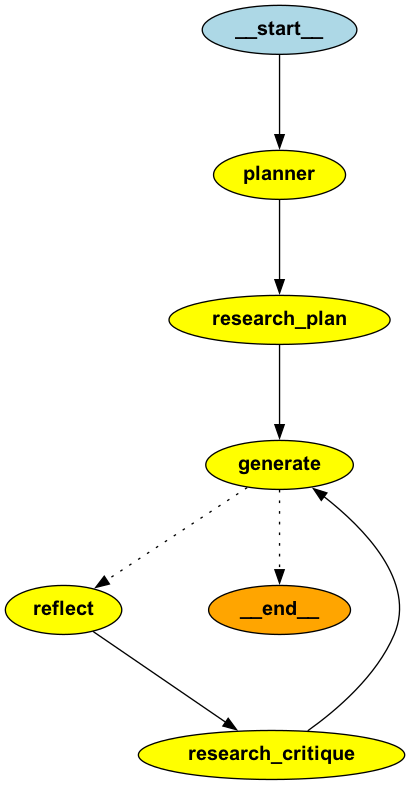

In [24]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [25]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'Title: Exploring the Differences: LangChain vs. LangSmith\n\nIntroduction:\n- Brief overview of the increasing role of language models in technology.\n- Introduction to LangChain and LangSmith as tools built on language models.\n- Statement of intent to explore their differences, functionalities, and applications.\n\nI. Understanding LangChain\n   A. Definition and Purpose\n      - Explanation of what LangChain is.\n      - Discussion on its primary function and target users.\n   B. Core Features\n      - Detailed description of key features such as modular design, focus on chaining APIs, and flexibility in integrating external data.\n   C. Use Cases\n      - Examples of scenarios or projects where LangChain is ideally suited.\n      - Highlight specific industries or domains benefiting from LangChain.\n\nII. Understanding LangSmith\n   A. Definition and Purpose\n      - Explanation of what LangSmith is.\n      - Discussion on its primary function and target users

In [27]:
!pip install helper

  Preparing metadata (setup.py) ... done
  Created wheel for helper: filename=helper-2.5.0-py2.py3-none-any.whl size=19169 sha256=4b4238c65dc8d48951bb791018213578b8dacb3719d35c0623be07268f8d030c
  Stored in directory: /Users/eumenides/Library/Caches/pip/wheels/13/8a/92/4a4267b8371d6e453121c917021173b4a682d691f123b9f647
Successfully built helper


In [28]:
import warnings
warnings.filterwarnings("ignore")
from helper import ewriter, writer_gui

ImportError: cannot import name 'ewriter' from 'helper' (/Users/eumenides/miniforge3/envs/langgraph/lib/python3.10/site-packages/helper/__init__.py)